In [1]:
import functools
import operator
import os

import anndata as ad
#import faiss
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import scipy.stats
import seaborn as sns
import sklearn.cluster
import torch

import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics
from matplotlib import rcParams
from networkx.algorithms.bipartite import biadjacency_matrix

import scglue
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

from utils.test_util_v2 import test_data_multiome, Siamese_Test_multiome
from utils.feature_util import feature_selection_multiome
#import utils.cis_infer_util as cis_infer_util


/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Run SiaNN

In [3]:
input_mod1 = ad.read_h5ad('../../fig2/PBMC_data/data/PBMC_10X_GEX.h5ad')
input_mod2 = ad.read_h5ad('../../fig2/PBMC_data/data/PBMC_10X_ATAC.h5ad')
used_cts = {
    "CD4 Naive", "CD4 TCM", "CD4 TEM", "CD8 Naive", "CD8 TEM_1", "CD8 TEM_2",
    "CD14 Mono", "CD16 Mono", "Memory B", "Naive B"
}  # To match cell types covered in PC Hi-C

input_mod1 = input_mod1[[item in used_cts for item in input_mod1.obs["seurat_annotations"]],:]
input_mod2 = input_mod2[[item in used_cts for item in input_mod2.obs["seurat_annotations"]],:]

input_mod1, input_mod2 = feature_selection_multiome(input_mod1, input_mod2, path='./utils')


Complementing missing feaures with 0
Complementing missing feaures with 0


In [4]:
import scanpy as sc
sc.pp.scale(input_mod1, max_value=10)
sc.pp.scale(input_mod2, max_value=10)
input_mod1.X = np.nan_to_num(input_mod1.X, nan=0)
input_mod1.X = sp.sparse.csr_matrix(input_mod1.X)
input_mod2.X = sp.sparse.csr_matrix(input_mod2.X)


/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:786: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


In [5]:
test_dat = test_data_multiome(mod1=input_mod1,
                              mod2=input_mod2,
                              batch_number=500)
SiaNN = Siamese_Test_multiome(test_dat, num_peaks=6532, num_genes=6532)
ckpt_loader = torch.load('utils/SiaNN.ckpt')
SiaNN.D.load_state_dict(ckpt_loader)

Normalizing data to range between 0 and 1...


<All keys matched successfully>

In [6]:
out_x, out_y, class_x, class_y = SiaNN.test()

In [7]:
np.isnan(input_mod1.X.toarray()).any()

False

In [8]:
np.isnan(out_x).any()

False

In [9]:
ct_int = input_mod1.obs['seurat_annotations'].cat.codes.to_numpy().astype('int')
ct_name = input_mod1.obs['seurat_annotations'].to_numpy()
ct_dic = {}
for i in range(len(np.unique(ct_int))):
    ct_dic[i] = ct_name[ct_int==i][0]
ct_int = np.concatenate((ct_int, ct_int), axis=0)


In [10]:
merge = np.concatenate((out_x, out_y), axis=0)
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = np.concatenate((ct_name, ct_name), axis=0)
domains = np.zeros(len(merge))
domains = domains.astype('str')
domains[0:len(merge)//2] = 'GEX'
domains[len(merge)//2:] = 'ATAC'
#domains = domains.astype('int')
ann_merge.obs['tech'] = domains
ann_merge.obs['tech'] = ann_merge.obs['tech'].astype("category")

... storing 'cell_type' as categorical


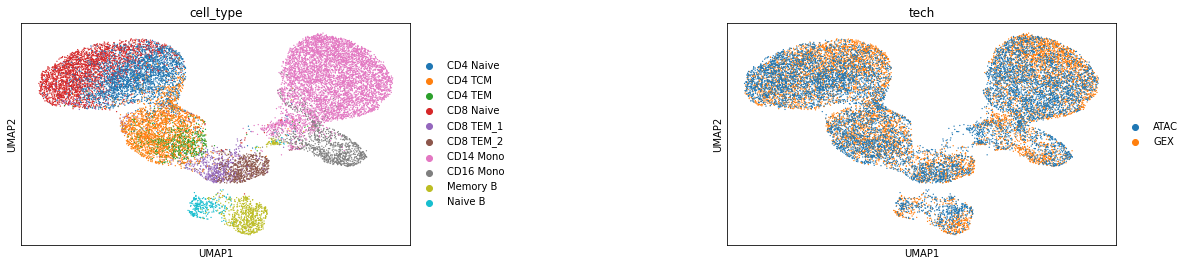

In [11]:
import scanpy as sc
sc.pp.neighbors(ann_merge, use_rep="X", metric="cosine")
#sc.tl.umap(ann_merge)
#sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)

#sc.tl.pca(ann_merge, svd_solver='arpack')
#sc.pp.neighbors(ann_merge, n_pcs = 20, n_neighbors = 20)
sc.tl.umap(ann_merge)
sc.pl.umap(ann_merge, color=["cell_type", "tech"], wspace=0.65)


In [12]:
merge = np.concatenate((out_x, out_y), axis=0)
merge = pd.DataFrame(merge)
merge.insert(0, 'index', np.concatenate((input_mod1.obs_names.to_numpy(), 
                                         input_mod2.obs_names.to_numpy()), axis=0))
merge.to_csv('embed/SiaNN_embed.pbmc.txt', index=False)